In [2]:
import tensorflow as tf


# Get list of available GPU devices
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print("GPU is available")
    # Additional information about GPUs
    for gpu in gpu_devices:
        print(gpu)
else:
    print("GPU is not available")

GPU is available
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


----------

In [3]:
%%capture
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Aptos Blindness Detection

In [4]:
#Importing the data

train = pd.read_csv("C:/Users/RAZER/Downloads/dataset/aptos/train.csv")
test = pd.read_csv("C:/Users/RAZER/Downloads/dataset/aptos/test.csv")
#submission= pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [5]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

Number of train samples:  3662
Number of test samples:  1928


In [7]:
N_CLASSES = train['diagnosis'].nunique()
N_CLASSES

5

In [8]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


## Keras Model

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)


train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="C:/Users/RAZER/Downloads/dataset/aptos/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')



Found 2930 validated image filenames belonging to 5 classes.


In [10]:
train_datagen

In [10]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="C:/Users/RAZER/Downloads/dataset/aptos/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation')

Found 732 validated image filenames belonging to 5 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "C:/Users/RAZER/Downloads/dataset/aptos/test_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


## ResNet50

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=5)


In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
history = model.fit(train_generator, epochs=2, validation_data=valid_generator)

Epoch 1/2
184/184 [==============================] - 305s 2s/step - loss: 1.1409 - accuracy: 0.6444 - val_loss: 3.0189 - val_accuracy: 0.3019
Epoch 2/2
184/184 [==============================] - 272s 1s/step - loss: 0.8618 - accuracy: 0.6962 - val_loss: 1.6454 - val_accuracy: 0.2801


In [ ]:
#model.save('imagenet_model.h5')

In [ ]:
loss, accuracy = model.evaluate(train_generator)
print("Train loss:", loss, "Train accuracy:", accuracy)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss, "Test accuracy:", test_accuracy)

In [ ]:
val_loss, val_accuracy = model.evaluate(valid_generator)
print("Validation loss:", val_loss, "Val accuracy:", val_accuracy)

In [ ]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

## VGG16

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of output classes


In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


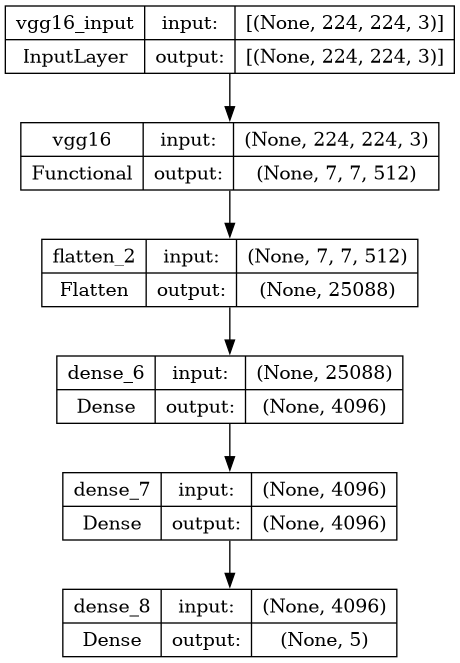

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)

In [25]:
history = model.fit(train_generator, epochs=3, validation_data=valid_generator)

Epoch 1/3
184/184 [==============================] - 460s 2s/step - loss: 115.2632 - accuracy: 0.5700 - val_loss: 12.4778 - val_accuracy: 0.5765
Epoch 2/3
184/184 [==============================] - 363s 2s/step - loss: 4634.2285 - accuracy: 0.5891 - val_loss: 3.0170 - val_accuracy: 0.6776
Epoch 3/3
184/184 [==============================] - 365s 2s/step - loss: 362.4252 - accuracy: 0.6379 - val_loss: 5.2343 - val_accuracy: 0.6079


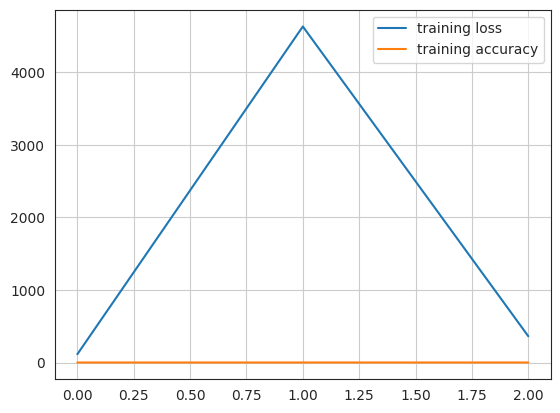

In [26]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=False)

# Train the model with the TensorBoard callback
history = model.fit(train_generator,
                    epochs=3,
                    validation_data=valid_generator,
                    callbacks=[tensorboard_callback])

Epoch 1/3
184/184 [==============================] - 384s 2s/step - loss: 234.6885 - accuracy: 0.6232 - val_loss: 1.6978 - val_accuracy: 0.5615
Epoch 2/3
184/184 [==============================] - 505s 3s/step - loss: 988.5685 - accuracy: 0.6488 - val_loss: 1.2849 - val_accuracy: 0.6776
Epoch 3/3
184/184 [==============================] - 495s 3s/step - loss: 18.1655 - accuracy: 0.6751 - val_loss: 1.6721 - val_accuracy: 0.7063


------------------------------------------
------------------------------------------

# Catarac Dataset

## tensoreflow

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# Define paths to your dataset folders
train_data_dir = "C:/Users/RAZER/Downloads/dataset/Cataract/dataset"
#validation_data_dir = '/path/to/your/dataset/validation'

# Create ImageDataGenerator instances for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,validation_split=0.2)
#validation_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # assuming you have multiple classes
    subset='training'
)



validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 481 images belonging to 4 classes.


Found 120 images belonging to 4 classes.


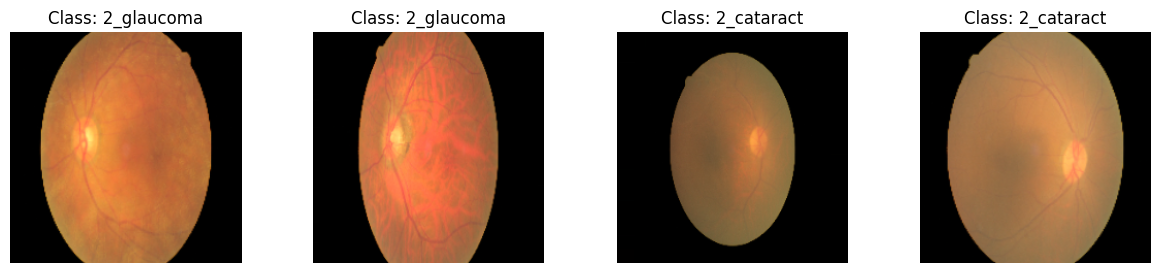

In [10]:
import matplotlib.pyplot as plt

# Get one image from each class in the training generator
num_classes = len(train_generator.class_indices)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i in range(num_classes):
    # Get a batch of images for the current class
    class_images, class_labels = next(train_generator, 1)
    
    # Take the first image from the batch
    image = class_images[0]
    
    # Display the image with the class label
    label_index = list(class_labels[0]).index(1)
    class_name = [class_name for class_name, index in train_generator.class_indices.items() if index == label_index][0]
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}')
    axes[i].axis('off')  # Turn off axis for better visualization

plt.show()


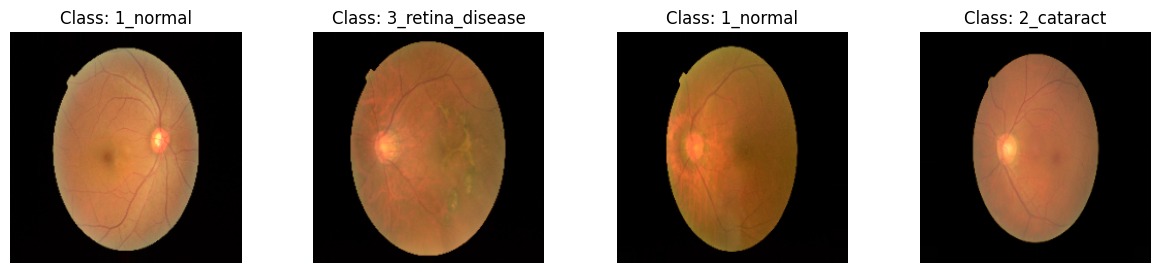

In [11]:
import matplotlib.pyplot as plt

# Get one image from each class in the validation generator
num_classes = len(validation_generator.class_indices)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i in range(num_classes):
    # Get a batch of images for the current class
    class_images, class_labels = next(validation_generator, 1)
    
    # Take the first image from the batch
    image = class_images[0]
    
    # Display the image with the class label
    label_index = list(class_labels[0]).index(1)
    class_name = [class_name for class_name, index in validation_generator.class_indices.items() if index == label_index][0]
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}')
    axes[i].axis('off')


### Resnet50

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=4)


In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
16/16 [==============================] - 68s 4s/step - loss: 2.9959 - accuracy: 0.3680 - val_loss: 1.5715 - val_accuracy: 0.5000
Epoch 2/5
16/16 [==============================] - 52s 3s/step - loss: 1.2522 - accuracy: 0.5301 - val_loss: 1.4094 - val_accuracy: 0.5000
Epoch 3/5
16/16 [==============================] - 51s 3s/step - loss: 1.2415 - accuracy: 0.5364 - val_loss: 1.2755 - val_accuracy: 0.5000
Epoch 4/5
16/16 [==============================] - 53s 3s/step - loss: 1.4076 - accuracy: 0.4324 - val_loss: 1.3182 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 52s 3s/step - loss: 1.2303 - accuracy: 0.5509 - val_loss: 14.5735 - val_accuracy: 0.5000


In [16]:
loss, accuracy = model.evaluate(train_generator)
print("Train loss:", loss, "Train accuracy:", accuracy)

16/16 [==============================] - 44s 3s/step - loss: 1.5054 - accuracy: 0.3555
Train loss: 1.5053950548171997 Train accuracy: 0.35550934076309204


In [17]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation loss:", val_loss, "Val accuracy:", val_accuracy)

4/4 [==============================] - 11s 3s/step - loss: 1.4175 - accuracy: 0.3833
Validation loss: 1.4175338745117188 Val accuracy: 0.38333332538604736


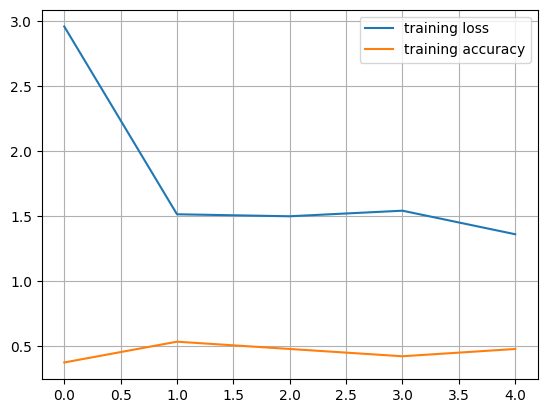

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

### VGG16

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # Adjust the number of output classes



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
16/16 [==============================] - 56s 3s/step - loss: 9.9175 - accuracy: 0.3243 - val_loss: 1.3676 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 58s 4s/step - loss: 1.2527 - accuracy: 0.5010 - val_loss: 1.1650 - val_accuracy: 0.5167
Epoch 3/50
16/16 [==============================] - 55s 3s/step - loss: 1.1399 - accuracy: 0.5676 - val_loss: 1.0285 - val_accuracy: 0.6000
Epoch 4/50
16/16 [==============================] - 59s 4s/step - loss: 1.2028 - accuracy: 0.5489 - val_loss: 1.3150 - val_accuracy: 0.2583
Epoch 5/50
16/16 [==============================] - 53s 3s/step - loss: 1.1077 - accuracy: 0.5447 - val_loss: 1.0375 - val_accuracy: 0.5750
Epoch 6/50
16/16 [==============================] - 51s 3s/step - loss: 1.1414 - accuracy: 0.5676 - val_loss: 1.2979 - val_accuracy: 0.5000
Epoch 7/50
16/16 [==============================] - 51s 3s/step - loss: 1.1496 - accuracy: 0.4802 - val_loss: 1.0856 - val_accuracy: 0.6000
Epoch 8/50
16/16 [==